The goal of this noteook is to attempt to reproduce the behavior of the Equations in Ghazaryan et al. using the network library infrastructure that I have built up so far.

In [1]:
# Importin my needed libraries
import numpy as np 
from matplotlib import pyplot as plt
import networkx as nx
import DynaNet
import Equations

from numpy import linalg

The situation that I am reproducing directly from Ghazaryan, 
>Traveling wave profiles for parameters $\gamma=1000$, $\beta=20$, $p=2$, $\omega=0.1$, $\alpha=1$, $c=2$.

In order to do this with my library, I am considering a multiplexed network consisting of two line networks to simulate the 1D behavior of the coupled equations. That is, there are two idential discretizations of a straight line sharing a node set and coupled at every node. The next issue is that their work uses a change of variables to a stationary frame. This is difficult to interpret in a graph framework, so I will instead use some post-processing to make an analogous frame shift

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.

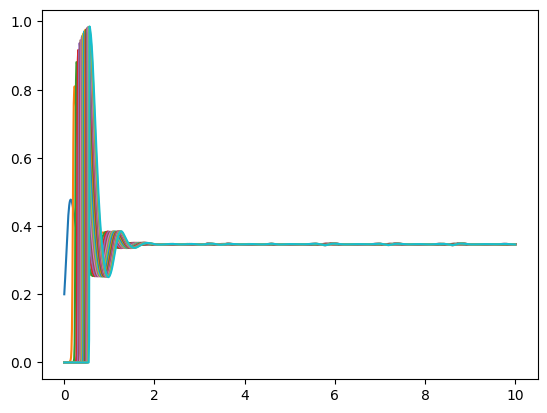

In [9]:
# Set graph parameters
graph_size = 20

# Line graphs
ident = np.identity(graph_size)
adj = np.roll(ident, 1) + np.roll(ident, -1) 
adj[0, 0] = 0
adj[graph_size-1, graph_size-1] = 0
online, offline = adj, adj
print(adj)

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-0.001 for ii in range(graph_size)] + [-0.002 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1

def coupling(state):
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = 10*(-u + 1000*u*(1-u)/(1+np.exp(-20*(v-1))))
    v_next = 1-v*(1+u)**2
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0
tf = 10
nt = 1000
A, k, B = 0.2, 10, .7
u0 = A*np.exp(-k*np.arange(graph_size))
v0 = B*np.ones(graph_size)
f0 = np.concatenate((u0, v0))

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

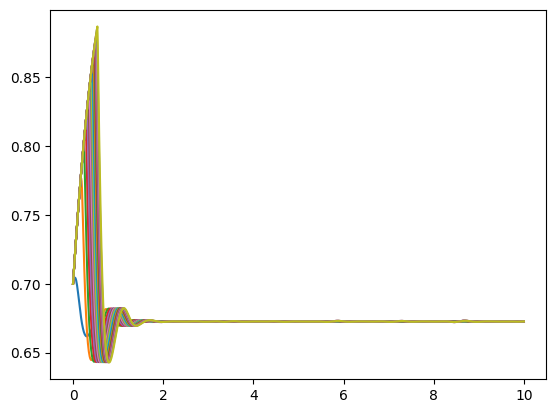

In [10]:
for ii in range(graph_size, 2*graph_size-1):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

Now we try to plot these curves in traveling wave style. This means letting $\xi = x-ct$. But since $x$ is discrete in this case, $\xi$ is also necesarily discrete. To remedy this, we fix an x atour halfway node, (node 24 in this case)

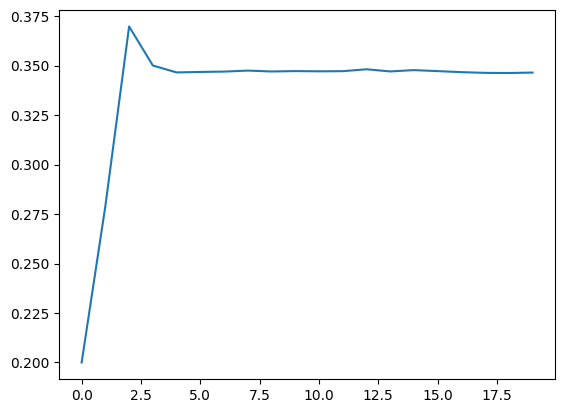

In [11]:
cross_section = np.array([res.y[ii, np.argmin(np.abs(res.t-ii/2))] for ii in range(graph_size)])
plt.plot(range(graph_size), cross_section)

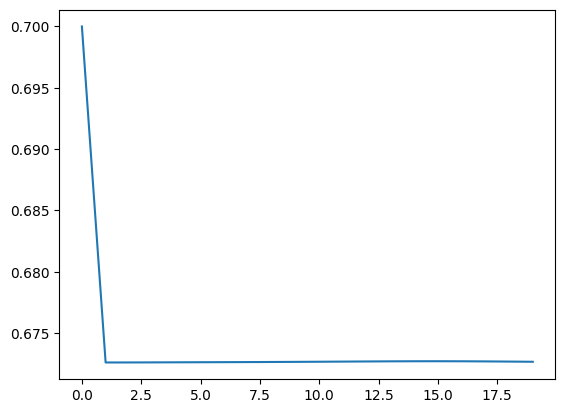

In [12]:
cross_section = np.array([res.y[ii, np.argmin(np.abs(res.t-(ii-graph_size)/0.02))] for ii in range(graph_size, 2*graph_size)])
plt.plot(range(graph_size), cross_section)

In [13]:
from mpl_toolkits.mplot3d import axes3d

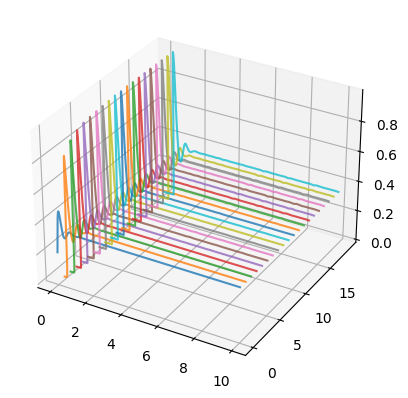

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

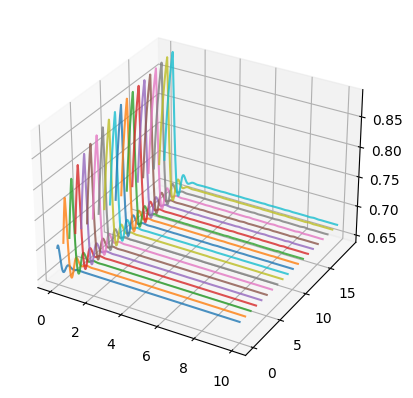

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii+graph_size, :], zs=ii, zdir='y', alpha=0.8)

Which looks like what we expect for the regime. I can verify later. But the other shape is to come.

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


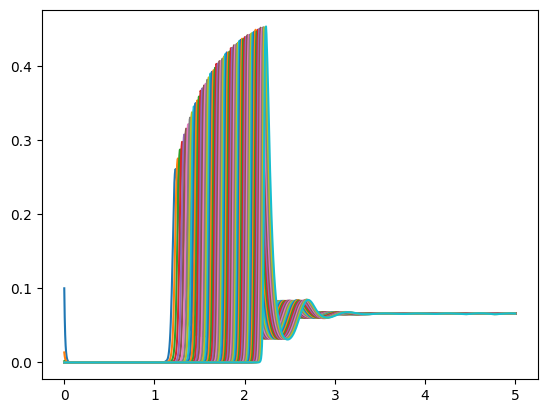

In [16]:
# Set graph parameters
graph_size = 60

# Line graphs
ident = np.identity(graph_size)
adj = np.roll(ident, 1) + np.roll(ident, -1) 
adj[0, 0] = 0
adj[graph_size-1, graph_size-1] = 0
online, offline = adj, adj
print(adj)

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-0.001 for ii in range(graph_size)] + [-0.002 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1

def coupling(state):
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = 100*(-u + 5*u*(1-u)/(1+np.exp(-20*(v-1))))
    v_next = 1-v*(1+u)**2
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0
tf = 5
nt = 1000
A, k, B = .1, 2, .7
u0 = A*np.exp(-k*np.arange(graph_size))
v0 = B*np.ones(graph_size)
f0 = np.concatenate((u0, v0))
f0.astype(dtype=np.longdouble)

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

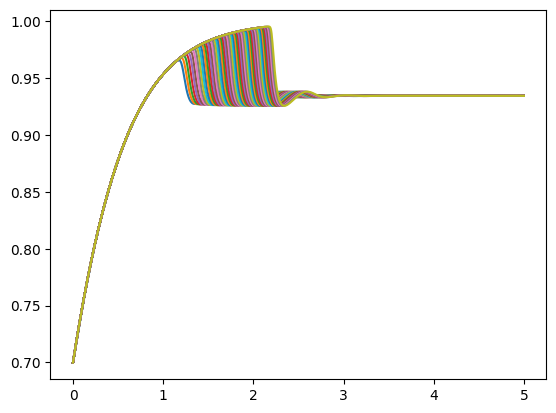

In [17]:
for ii in range(graph_size, 2*graph_size-1):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

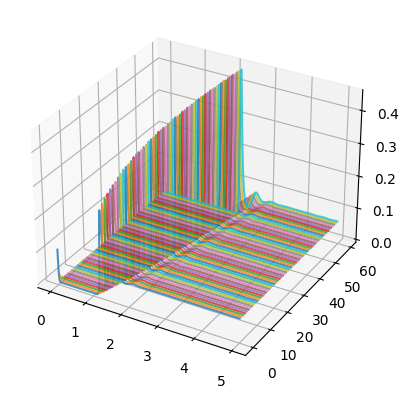

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

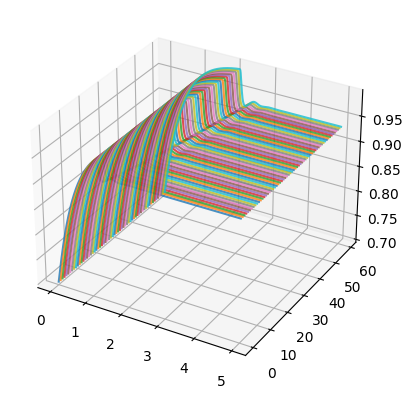

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii+graph_size, :], zs=ii, zdir='y', alpha=0.8)

Which reproduces figure 7 from Ghazaryan if we take a cross section in time

We can add to this by using a graph visualization tool to cooked up

In [14]:
# Enable interactive plot
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors

<IPython.core.display.Javascript object>


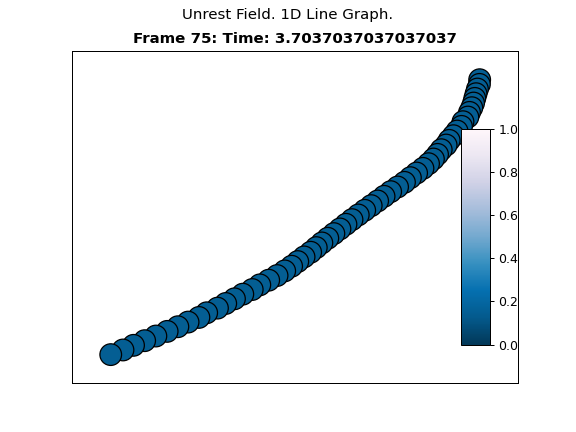

MovieWriter ffmpeg unavailable; using Pillow instead.


In [26]:
G = nx.from_numpy_array(adj)
pos = nx.spring_layout(G)
#fig, ax = plt.subplots()

def animation_prep(res_y, res_t, time_rate):
    
    # Get max and min for normalized colors
    vmin = np.min(res_y)
    vmax = np.max(res_y)
    
    def update(frame):
        
        # Clear out axes
        ax.clear()

        # Get weights for this specific frame for coloring
        color_weights = res_y[:, frame*time_rate]
        
        # Draw out our edges
        nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="gray")
        null_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=G.nodes, node_color=color_weights,  ax=ax, cmap="PuBu_r", vmin=vmin, vmax=vmax)
        null_nodes.set_edgecolor("black")
        
        ax.set_title(f"Frame {frame+1}: Time: {res_t[frame*time_rate]}", fontweight="bold")
        ax.set_xticks([])
        ax.set_yticks([])
     
    return update

# Try thresholding
us = res.y[0:60, :]
vmax = np.max(us, axis=0)
vmin = np.min(us, axis=0)
thresholded = np.where(us>=(vmax+vmin)/2, vmax, vmin)

fig, update = DynaNet.visualize(thresholded, res.t, adj, 10)

#update = animation_prep(res.y[:60, :], res.t, 10)
fig.suptitle("Unrest Field. 1D Line Graph.")
ani = animation.FuncAnimation(fig, update, 100, repeat=True, blit=True)
ani.save("GarzyanUField.gif")

In [44]:
import importlib
importlib.reload(DynaNet)

<module 'DynaNet' from 'C:\\Users\\wrmag\\Documents\\School\\Spring 23\\RAShip\\DynamicNetwork\\DynaNet.py'>

<IPython.core.display.Javascript object>


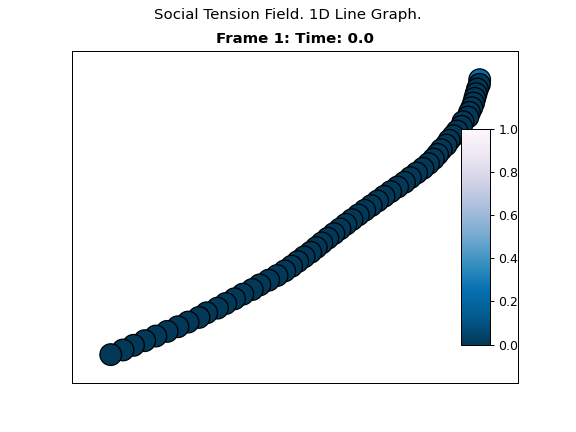

MovieWriter ffmpeg unavailable; using Pillow instead.


In [25]:
# Try thresholding
vs = res.y[60:120, :]
vmax = np.max(us, axis=0)
vmin = np.min(us, axis=0)
thresholded = np.where(us>=(vmax+vmin)/2, vmax, vmin)

fig, update = DynaNet.visualize(thresholded, res.t, adj, 10)
fig.suptitle("Social Tension Field. 1D Line Graph.")
ani = animation.FuncAnimation(fig, update, 100, repeat=True, blit=True)
ani.save("GarzyanVField.gif")